# Masterthesis: Preprocessing Player Data

In [1]:
# Specify data range in scope
#scope_split_list = ['2017-2', '2017-2po', '2017-2rq', '2017-2pr', '2017-1', '2017-1po',
#                    '2017-1pr']
#scope_split_list = ['2017-2', '2017-2po', '2017-2rq', '2017-2pr', '2017-1', '2017-1po',
#                    '2017-1pr', '2017-W', '2018-1', '2018-1P', '2018-2rq', '2018-2', '2018-2p']
scope_split_list = ['2017-2', '2017-2po', '2017-2rq', '2017-2pr', '2017-1', '2017-1po',
                    '2017-1pr', '2017-W', '2018-1', '2018-1P', '2018-2rq', '2018-2', 
                    '2018-2p', '2018-W', '2019-1', '2019-1P', '2019-2']

In [2]:
# Name of the preprocessed datafile written away
#filename = 'playerdata2017_preprocessed'
#filename = 'playerdata2018_preprocessed'
filename = 'playerdata2019_preprocessed'

## 0. Load libraries and define functions

In [3]:
# Functions
import numpy as np
import os
import pickle
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from datetime import datetime
from collections import Counter
from numpy.random import choice
from scipy import stats
import operator
import itertools
import statistics

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
cm.get_cmap(name='tab20b')

In [5]:
### Function used to return a summary for categorical variables
def SummaryCategoricalVar(list_of_values, title, threshold = 15, top = 10):
    """
    param: list_of_values (list): A list of categorical values from which we like to obtain the distribution
    param: title (string): The title for the visualization
    param: threshold (int): The maximal number of categories that should be visualized
    param: top (int): The top k values that should be returned in the written summary when the number of categories is above the threshold
    """
    # Count the number of occurrances in the list
    cnt = Counter(list_of_values)
    sorted_cnt = sorted(cnt.items(), key=operator.itemgetter(1))[::-1]
    
    # Show the percentage dictionary if to many categories to represent
    print("-"* 100, "\nOverview of variable: ", title, "\n", "-"*100)
    print("Total categories:", len(cnt), "\n")
    if len(cnt) > threshold:
        if len(cnt) < top*2:
            for key, value in sorted_cnt:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
        else:
            print("The 10 with the highest percentage data available:\n")
            for key, value in sorted_cnt[:top]:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
            print("\nThe 10 with the lowest percentage data available:\n")
            for key, value in sorted_cnt[len(cnt) - top:]:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
                
    # Visualization of labelled data distribution
    else:
        plt.barh(range(1, len(sorted_cnt)+1), 
                 list(map(lambda x: (x/len(list_of_values)*100), [score for label, score in sorted_cnt])), 
                 tick_label = list([label for label, score in sorted_cnt]),
                 color = 'cornflowerblue', 
                 edgecolor = 'steelblue')
        plt.ylabel('Label')
        plt.xlabel('Percentage observations in dataset')
        plt.title(title)
        plt.show()    

In [6]:
### Function used to return a summary for numeric variables
def SummaryNumericVar(list_of_values, title):
    """
    param: list_of_values (list): A list of categorical values from which we like to obtain the distribution
    param: title (string): The title for the visualization
    """
    
    # Title varibale
    print("="* 100, "\nOverview of variable: ", title, "\n", "="*100)

    # An "interface" to matplotlib.axes.Axes.hist() method
    n, bins, patches = plt.hist(x = list_of_values, bins='auto', color= '#0504aa', alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.ylim(ymax=np.ceil(n.max() / 10) * 10 if n.max() % 10 else n.max() + 10)
    plt.show()

    # Print summary statistics
    print("-"*20, "\nSummary statistics:\n", "-"*20)
    print("Minimum value:", min(list_of_values))
    print("Mean:", round(statistics.mean(list_of_values), 4))
    print("Standard deviation:", round(statistics.stdev(list_of_values), 4))
    print("Median:", round(statistics.median(list_of_values), 4))
    print("Maximal value:", max(list_of_values))

    # Plot boxplot
    plt.boxplot(list_of_values, 0, 'grey', 0)
    plt.xlabel('Value')
    plt.title(title)
    plt.show()

    # Present outliers
    print("-"*20, "\nOutlier detection:\n", "-"*20)
    print("List of outliers:", {round(value,2) for z_score, value in zip(np.abs(stats.zscore(list_of_values)), list_of_values) if z_score > 3})

    # Check for normally distributed
    stats.probplot(list_of_values, dist="norm", plot= plt)
    plt.show()

    # Statistics to check normality
    print("-"*20, "\nCheck for normal distribution:\n", "-"*20)
    print("Skewedness:", round(stats.skew(list_of_values), 4))
    print("Kurtosis:", round(stats.kurtosis(list_of_values), 4))

In [7]:
### Function used to draw a random sample from the discrete distribution of probabilities representing the input list
def RandomSampleProbDist(list_of_values, draws = 1):
    """
    :param: list_of_values (list): A list of categorical values representing the observations in the dataset
    :param: draws (int): The number of samples desired to be returned
    :return: (array) An array capturing the sampled categories
    """
    # Only the non-missing values are considered in the sampling procedure
    non_missing_list = list_of_values.dropna()
    # Sample from the discrete probability distribution representing the categorical variable
    return list(choice(list(Counter(non_missing_list)), 
                  draws, 
                  p = list(map(lambda x: x/len(non_missing_list), 
                               Counter(non_missing_list).values()))))[0]

## 1. Load data

### 1.1 Extract raw data

#### Read in raw data xlsx format

In [8]:
# Load the data and create panda's dataframe
pd_df_2016 = pd.ExcelFile('Data/2016-complete-match-data-OraclesElixir-2017-09-18.xlsx')
pd_df_2017 = pd.ExcelFile('Data/2017matchdataOraclesElixir.xlsx')
pd_df_2018_spring = pd.ExcelFile('Data/2018-spring-match-data-OraclesElixir-2018-05-20.xlsx')
pd_df_2018_summer = pd.ExcelFile('Data/2018 summer match data OraclesElixir 2018-09-27.xlsx')
pd_df_2018_worlds = pd.ExcelFile('Data/2018-worlds-match-data-OraclesElixir-2018-11-03.xlsx')
pd_df_2019_spring = pd.ExcelFile('Data/2019-spring-match-data-OraclesElixir-2019-05-21.xlsx')
pd_df_2019_summer = pd.ExcelFile('Data/2019-summer-match-data-OraclesElixir-2019-08-19.xlsx')

# Put the data in a dataframe
df_2016 = pd_df_2016.parse(0)
df_2017 = pd_df_2017.parse(0)
df_2018_spring = pd_df_2018_spring.parse(0)
df_2018_summer = pd_df_2018_summer.parse(0)
df_2018_worlds = pd_df_2018_worlds.parse(0)
df_2019_spring = pd_df_2019_spring.parse(0)
df_2019_summer = pd_df_2019_summer.parse(0)

# Check whether most recent datasets represent the same features
print(all(df_2017.columns == df_2018_spring.columns))
print(all(df_2017.columns == df_2018_summer.columns))
print(all(df_2017.columns == df_2018_worlds.columns))
print(all(df_2018_summer.columns == df_2019_summer.columns))
print(all(df_2017.columns == df_2019_summer.columns))

True
True
True
True
True


#### Concatenate dataframes

In [9]:
# Add extra column indicating the year of the data
df_2017['Year'] = ['2017' for i in range(len(df_2017))]
df_2018_spring['Year'] = ['2018' for i in range(len(df_2018_spring))]
df_2018_summer['Year'] = ['2018' for i in range(len(df_2018_summer))]
df_2018_worlds['Year'] = ['2018' for i in range(len(df_2018_worlds))]
df_2019_spring['Year'] = ['2019' for i in range(len(df_2019_spring))]
df_2019_summer['Year'] = ['2019' for i in range(len(df_2019_summer))]

In [10]:
# Initialize data you want to analyse
data_exploration = pd.concat([df_2017, df_2018_spring, df_2018_summer, df_2018_worlds, df_2019_spring, df_2019_summer])

#### Retain only split data in scope

In [11]:
# Retain data in scope 
data_exploration = data_exploration[data_exploration.split.isin(scope_split_list)]

### 1.2 Only retain team data from 1-1 matchups
Only player data is retained from matchups (based on the unique gameid identifier) in which two teams played against each other. 

In [12]:
# Retain team level parameter information
data_exploration = data_exploration[data_exploration.position != 'Team']

In [13]:
# Create dictionary capturing the team and its opponent during a matchup
matchup_dict = {}
for gameID in list(set(data_exploration.gameid)):
    matchup_df = data_exploration[data_exploration.gameid == gameID]
    matchup_dict[gameID] = set(matchup_df.team)

In [14]:
# Intermediate summary
print("The number of teams corresponding to the same game-id in the dataset:")
matchup_dict_counter = Counter([len(x) for x in matchup_dict.values()])
for ID, teams in matchup_dict_counter.items():
    print(ID, ":", teams)
print("\nWe are only interested in games involving two teams and hence removed the others from further analysis:")
print("Latter allowed us to retain", round(matchup_dict_counter[2]/sum(matchup_dict_counter.values())*100, 4) ,"% of the initial matchup data")
print("Information from", matchup_dict_counter[2], "are retained in the final dataset")

The number of teams corresponding to the same game-id in the dataset:
0 : 1
2 : 7757
4 : 47
3 : 2

We are only interested in games involving two teams and hence removed the others from further analysis:
Latter allowed us to retain 99.3595 % of the initial matchup data
Information from 7757 are retained in the final dataset


In [15]:
# Remove biased match-up data
unbiased_gameids = [gameID for gameID, teams in matchup_dict.items() if len(teams) == 2]
data_exploration = data_exploration[data_exploration['gameid'].isin(unbiased_gameids)]

### 1.3 Adjust Team and player parameter in dataset
The parameter describing the player was lowercased and the bias in spelling mistakes made and the use of different names to indicate the same player and was removed by manually exploring the data and creating a matching dictionary. All the players were retained in the final dataset (also the ones for which no strength parameters will be calculated) to allow us to build a model on as much data as possible. Latter preprocessing was considered as well for the team parameter.

In [16]:
# Adjust the player parameter in the data
list_of_players = [x.lower() if isinstance(x, str) else x for x in data_exploration.player]
data_exploration = data_exploration.drop(['player'], axis= 1)
data_exploration["player"] = list_of_players

In [17]:
# Team matching dictionary
team_dict = {'100 thieves': ['100 thieves', '100 thieves academy'],
             'ahq': ['ahq e-sports club', 'ahq fighter'],
             'cloud9': ['cloud9', 'cloud9 academy'],
             'clutch gaming': ['clutch gaming', 'clutch gaming academy'],
             'cbn': ['cbn', 'cnb e-sports club'],
             'counter logic gaming': ['counter logic gaming', 'clg academy'],
             'echo fox': ['echo fox', 'echo fox academy'],
             'flyquest': ['flyquest', 'flyquest academy'],
             'flamengo': ['flamengo', 'flamengo esports'],
             'fnatic': ['fnatic', 'fnatic academy'],
             'giants': ['giants', 'giants gaming'],
             'golden guardians': ['golden guardians', 'golden guardians academy'],
             'intz': ['intz', 'intz e-sports', 'intz e-sports club'],
             'kabum': ['kabum', 'kabum e-sports', 'kabum esports'],
             'kongdoo monster': ['kongdoo mongster', 'kongdoo monster'],
             'misfits': ['misfits', 'misfits academy'],
             'optic': ['optic academy', 'optic gaming'],
             'redemption': ['redemption', 'redemption esports'],
             'rogue': ['rogue', 'rogue warriors'],
             'suning': ['suning', 'suning gaming'],
             'team liquid': ['team liquid', 'team liquid academy'],
             'team one': ['team one', 'team one e-sports', 'team one esports'],
             'top esports': ['top esports', 'topsports gaming']}

team_match_dict = {v:k for k, v_list in team_dict.items() for v in v_list}

In [18]:
# Adjust the team parameter in the data
list_of_teams = [x.lower() for x in data_exploration.team]
data_exploration = data_exploration.drop(['team'], axis= 1)
unbiased_teamlist = [team_match_dict[team] if team in team_match_dict else team for team in list_of_teams]
data_exploration["team"] = unbiased_teamlist

## 2 Create extra features

### 2.1 Culture

In [19]:
# Create dictionary matching the league with its corresponding culture
culture_dict = {'CBLoL': 'Brazil', 'EULCS': 'Europe', 'LCK': 'Korea',
                'LMS': 'Taiwan, Hong Kong & Macau', 'LPL': 'China',
                'NALCS': 'North America', 'TCL': 'Turkey',
                'LCL': 'Commonwealth of Independent States', 'LJL': 'Japan',
                'LLN': 'Latin America - North', 'OPL': 'Oceania', 
                'GPL': 'Southeast Asia', 'VCS': 'Vietnam',
                'WC': 'International', 'MSI': 'International',
                'EUPR': 'Europe', 'NAAc': 'North America',
                'EUCS': 'Europe', 'NAPR': 'North America',
                'NACS': 'North America'}

data_exploration['culture'] = [culture_dict[l] if l in culture_dict else np.nan for l in data_exploration['league']]

# Intermediate summary
if not set(data_exploration['league']).issubset(set(culture_dict.keys())):
    print("Not all leagues could be represented by the dictionary used, the ones for which no match was found: ",
          set(data_exploration['league']) - set(culture_dict.keys()))

Not all leagues could be represented by the dictionary used, the ones for which no match was found:  {'RRNAEU', 'LEC', 'LCS', 'RRAsia'}


### 2.2 Recency of game played

In [20]:
# Time indicator (days since game was last played)
dates = [datetime.utcfromtimestamp((x- 25569) * 86400.0) if isinstance(x, float) else datetime.utcfromtimestamp(0) for x in data_exploration["date"]]

# Calculate the date difference with today
daydiff = [(datetime.now() - x).days if not x == datetime.utcfromtimestamp(0) else np.NaN for x in dates]


# At column with date difference indicator to the dataframe and drop unicode indications 
data_exploration["datediff"] = daydiff
data_exploration = data_exploration.drop(['date'], axis= 1)

### 2.3 Match importance
In the data the following abbreviations are used to define the split: The year the game was played combined with a specific suffix (1 spring, 2 summer, po playoffs, r regionals, w worlds). Based on expert knowledge a matchimportance ranking was done.

In [21]:
# Initialization of match importance
match_imp_dict = {'1':1, '2':2, 'W':4, 'po':1.5, '2017':1, '2018':2, '2019':2}

# Extract rank information needed to process match importance
matchimp_list = [s.split('-') for s in set(data_exploration['split']) if s != 'nan']

# Create dictionary for mapping
match_imp_mapping_dict = dict()
for year, split in matchimp_list:
    playoff = match_imp_dict['po'] if any(s in split for s in ['po', 'rq', 'pr']) else 1
    match_imp_mapping_dict[year + '-' + split] = match_imp_dict[year] * match_imp_dict[split[0]] *playoff    

# Map the values of the dataframe for the different patch numbers
data_exploration['split'] = [match_imp_mapping_dict[s] if s in match_imp_mapping_dict else np.nan for s in data_exploration['split']]

### 2.4 Patch number
The patch number will be ranked in an ordinal fashion, giving higher values to more recent patches. There was no magnitude based ranking used because of its irrelevance for this specific situation.

In [22]:
# Extract rank information needed to process patch number
patchno_split_list = [str(patchno).split('.') for patchno in set(data_exploration['patchno']) if any(char.isdigit() for char in str(patchno))]
patchno_split_list = [[int(p), int(n)] if len(n) == 2 else [int(p), int(n + '0')] for p, n in patchno_split_list]
patch_sorted, no_sorted = sorted(list(set([p for p, n in patchno_split_list]))), sorted(list(set([n for p, n in patchno_split_list])))

# Create dictionary for mapping
patchno_mapping_dict, counter = dict(), 0
for patch in patch_sorted:
    for no in no_sorted:
        # Customize patch number
        if len(str(no)) == 1:
            custom_no = '0' + str(no)
        elif str(no)[-1] == '0':
            custom_no = str(no)[:-1]
        else: 
            custom_no = str(no)
        # Fill matching dictionary
        patchno_mapping_dict[str(patch) + '.' + custom_no] = counter
        counter += 1

# Map the values of the dataframe for the different patch numbers
data_exploration['patchno'] = [patchno_mapping_dict[str(patchno)] if str(patchno) in patchno_mapping_dict else np.nan for patchno in data_exploration['patchno']]

## 3. Drop irrelevant features
Information provided by the url kolom and the opp-features captured by the dataset can assumed to be irrelevant, because latter show high collinearity with other features present in the dataset. Hence, it was decided upon removing these features to avoid them from biasing our results any further.

In [23]:
# Drop irrelevant feature url and opponent scores
data_exploration = data_exploration.drop(labels=['url', 'week', 'playerid', 'teamkills', 'teamdeaths', 'fbtime', 'ckpm', 'fdtime', 
                                                 'teamdragkills', 'oppdragkills', 'oppelementals', 'oppelders', 'heraldtime',
                                                 'ft', 'fttime', 'firstmidouter', 'firsttothreetowers', 'teamtowerkills',
                                                 'opptowerkills', 'fbaron', 'fbarontime', 'teambaronkills', 'oppbaronkills',
                                                 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'gamelength', 'okpm', 'oppgoldat10',
                                                 'oppgoldat15', 'oppxpat10', 'oppcsat10', 'oppcsat15'], axis=1)

### 4. Assign correct feature type

In [24]:
# Extract variables to be analysed
categorical_variables = ['gameid', 'league', 'game', 'side', 'position', 'champion', 'Year', 'player',
                         'culture', 'team']
numerical_variables = ['split', 'patchno', 'result', 'k', 'd', 'a', 'doubles', 'triples', 
                       'quadras', 'pentas', 'fb', 'fbassist', 'fbvictim', 'kpm', 'fd',
                       'elementals', 'firedrakes', 'waterdrakes', 'earthdrakes', 'airdrakes',
                       'elders', 'herald', 'dmgtochamps', 'dmgtochampsperminute', 'dmgshare',
                       'earnedgoldshare', 'wards', 'wpm', 'wardshare', 'wardkills', 'wcpm',
                       'visionwards', 'visionwardbuys', 'visiblewardclearrate', 'invisiblewardclearrate',
                       'totalgold', 'earnedgpm', 'goldspent', 'gspd', 'minionkills', 'monsterkills',
                       'monsterkillsownjungle', 'monsterkillsenemyjungle', 'cspm', 'goldat10', 'gdat10',
                       'goldat15', 'gdat15', 'xpat10', 'xpdat10', 'csat10', 'csdat10', 'csat15', 'csdat15',
                       'datediff']

# Correctly define feature types 
for i in data_exploration.columns.values:
    if i in categorical_variables:
        data_exploration[i] = data_exploration[i].astype(str)
    elif i in numerical_variables:
        data_exploration[i]= pd.to_numeric(data_exploration[i], errors='coerce')

## 6. Correct initialization of missing values

In [25]:
# Copy dataframe
data_preparation = data_exploration.copy()

In [26]:
# Replace missing values with appropriate indicator
data_preparation = data_preparation.replace(to_replace = 'nan', value= np.NaN)
data_preparation = data_preparation.replace(to_replace = ' ', value= np.NaN)

### 6.0 Create Position dependent dataframes

In [27]:
# Create different dataframes depending on the position occupied by the player
data_dict = dict()
data_dict['Top'] = data_preparation[data_preparation.position == 'Top']
data_dict['Middle'] = data_preparation[data_preparation.position == 'Middle']
data_dict['Jungle'] = data_preparation[data_preparation.position == 'Jungle']
data_dict['ADC'] = data_preparation[data_preparation.position == 'ADC']
data_dict['Support'] = data_preparation[data_preparation.position == 'Support']

# Short intermediate summary
print("The number of observations captured by each dataset:\n", "-"*100)
for pos, df in data_dict.items():
    print(pos, ':', len(df))

The number of observations captured by each dataset:
 ----------------------------------------------------------------------------------------------------
Top : 15514
Middle : 15514
Jungle : 15514
ADC : 15514
Support : 15514


### 6.1 Missing values per columns
Because the importance of the columns might dependent on the position occupied by a player, missing values are analyses in a dataframe independent fashion.



   Top 
---------------------------------------------------------------------------------------------------- 
Overview of variable:  The number of columns with a certain percentage of missing values 
 ----------------------------------------------------------------------------------------------------
Total categories: 14 



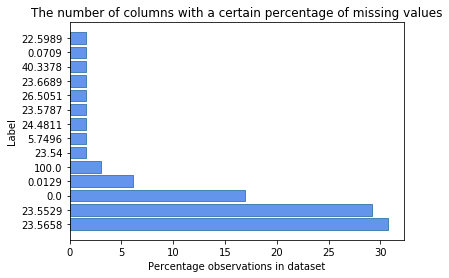

---------------------------------------------------------------------------------------------------- 
Broader exploration of the data
 ----------------------------------------------------------------------------------------------------
Total number of columns: 65 

Total number of columns with no missing values: 11 ( 16.9231 %)

These are the following columns: ['gameid', 'league', 'split', 'game', 'side', 'position', 'champion', 'result', 'Year', 'player', 'team'] 

The number of columns for which more than half of the information is missing: 2 ( 3.0769 %)

These are the following columns: ['visiblewardclearrate', 'invisiblewardclearrate']


   Middle 
---------------------------------------------------------------------------------------------------- 
Overview of variable:  The number of columns with a certain percentage of missing values 
 ----------------------------------------------------------------------------------------------------
Total categories: 14 



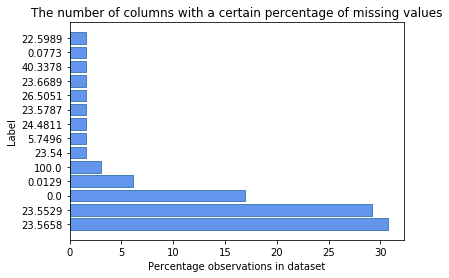

---------------------------------------------------------------------------------------------------- 
Broader exploration of the data
 ----------------------------------------------------------------------------------------------------
Total number of columns: 65 

Total number of columns with no missing values: 11 ( 16.9231 %)

These are the following columns: ['gameid', 'league', 'split', 'game', 'side', 'position', 'champion', 'result', 'Year', 'player', 'team'] 

The number of columns for which more than half of the information is missing: 2 ( 3.0769 %)

These are the following columns: ['visiblewardclearrate', 'invisiblewardclearrate']


   Jungle 
---------------------------------------------------------------------------------------------------- 
Overview of variable:  The number of columns with a certain percentage of missing values 
 ----------------------------------------------------------------------------------------------------
Total categories: 14 



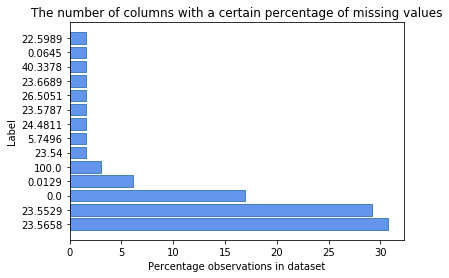

---------------------------------------------------------------------------------------------------- 
Broader exploration of the data
 ----------------------------------------------------------------------------------------------------
Total number of columns: 65 

Total number of columns with no missing values: 11 ( 16.9231 %)

These are the following columns: ['gameid', 'league', 'split', 'game', 'side', 'position', 'champion', 'result', 'Year', 'player', 'team'] 

The number of columns for which more than half of the information is missing: 2 ( 3.0769 %)

These are the following columns: ['visiblewardclearrate', 'invisiblewardclearrate']


   ADC 
---------------------------------------------------------------------------------------------------- 
Overview of variable:  The number of columns with a certain percentage of missing values 
 ----------------------------------------------------------------------------------------------------
Total categories: 14 



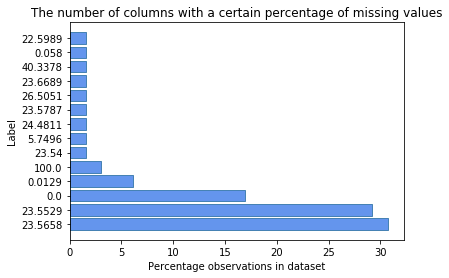

---------------------------------------------------------------------------------------------------- 
Broader exploration of the data
 ----------------------------------------------------------------------------------------------------
Total number of columns: 65 

Total number of columns with no missing values: 11 ( 16.9231 %)

These are the following columns: ['gameid', 'league', 'split', 'game', 'side', 'position', 'champion', 'result', 'Year', 'player', 'team'] 

The number of columns for which more than half of the information is missing: 2 ( 3.0769 %)

These are the following columns: ['visiblewardclearrate', 'invisiblewardclearrate']


   Support 
---------------------------------------------------------------------------------------------------- 
Overview of variable:  The number of columns with a certain percentage of missing values 
 ----------------------------------------------------------------------------------------------------
Total categories: 15 



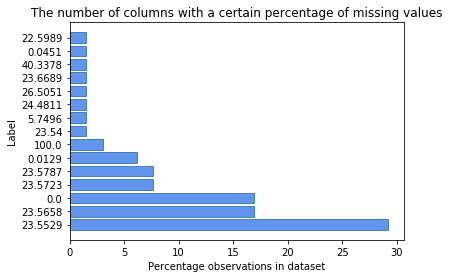

---------------------------------------------------------------------------------------------------- 
Broader exploration of the data
 ----------------------------------------------------------------------------------------------------
Total number of columns: 65 

Total number of columns with no missing values: 11 ( 16.9231 %)

These are the following columns: ['gameid', 'league', 'split', 'game', 'side', 'position', 'champion', 'result', 'Year', 'player', 'team'] 

The number of columns for which more than half of the information is missing: 2 ( 3.0769 %)

These are the following columns: ['visiblewardclearrate', 'invisiblewardclearrate']


In [28]:
# Loop through the different dataframes
for pos, df in data_dict.items():
    # Print represented position for visualization purposes
    print("\n\n","="*10, "\n  ", pos, "\n", "="*10)
    
    # Count of columns with a certain number of missing values
    percentage_missing_percol = [round(x/len(df)*100, 4) for x in list(df.isna().sum())]
    SummaryCategoricalVar(percentage_missing_percol,
                          'The number of columns with a certain percentage of missing values')

    # Print intermediate summary
    print("-"*100, "\nBroader exploration of the data\n", "-"*100)
    print("Total number of columns:", len(percentage_missing_percol), "\n")
    print("Total number of columns with no missing values:", 
          len([x for x in percentage_missing_percol if x == 0]),
         "(", round(len([x for x in percentage_missing_percol if x == 0])/len(percentage_missing_percol)*100, 4), "%)\n")
    print("These are the following columns:", [y for y, x in zip(df.columns, percentage_missing_percol) if x == 0], "\n")
    print("The number of columns for which more than half of the information is missing:", 
          len([x for x in percentage_missing_percol if x > 50]),
         "(", round(len([x for x in percentage_missing_percol if x > 50])/len(percentage_missing_percol)*100, 4), "%)\n")
    print("These are the following columns:", [y for y, x in zip(df.columns, percentage_missing_percol) if x > 50])

In [29]:
# Loop through the different dataframes
for pos, df in data_dict.items():
    # Print represented position for visualization purposes
    print("\n\n","="*10, "\n  ", pos, "\n", "="*10)
    
    # Remove the columns from the data in case more than half of the observations are missing
    columns_to_be_dropped = [y for y, x in zip(df.columns, percentage_missing_percol) if x > 50]
    df = df.drop(columns_to_be_dropped, axis=1)
    data_dict[pos] = df

    # Drop columns from indicator list for numerical and categorical variables list
    numerical_variables = [col for col in numerical_variables if col not in columns_to_be_dropped]
    categorical_variables = [col for col in categorical_variables if col not in columns_to_be_dropped]

    # Intermediate summary 
    print("After dropping columns with more than half missing values, namely:\n", columns_to_be_dropped)
    print(len(data_preparation.columns), "parameters are retained in the dataset.")



   Top 
After dropping columns with more than half missing values, namely:
 ['visiblewardclearrate', 'invisiblewardclearrate']
65 parameters are retained in the dataset.


   Middle 
After dropping columns with more than half missing values, namely:
 ['visiblewardclearrate', 'invisiblewardclearrate']
65 parameters are retained in the dataset.


   Jungle 
After dropping columns with more than half missing values, namely:
 ['visiblewardclearrate', 'invisiblewardclearrate']
65 parameters are retained in the dataset.


   ADC 
After dropping columns with more than half missing values, namely:
 ['visiblewardclearrate', 'invisiblewardclearrate']
65 parameters are retained in the dataset.


   Support 
After dropping columns with more than half missing values, namely:
 ['visiblewardclearrate', 'invisiblewardclearrate']
65 parameters are retained in the dataset.


### 6.2 Missing values per row



   Top 
---------------------------------------------------------------------------------------------------- 
Overview of variable:  The number of observations with a certain percentage of missing values 
 ----------------------------------------------------------------------------------------------------
Total categories: 10 



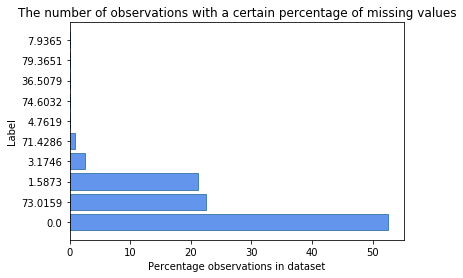

---------------------------------------------------------------------------------------------------- 
Broader exploration of the data
 ----------------------------------------------------------------------------------------------------
Total number of observations: 15514 

Total number of observations with no missing values: 8162 ( 52.6105 %)

The number of observations for which more than half of the information is missing: 3654 ( 23.5529 %)


   Middle 
---------------------------------------------------------------------------------------------------- 
Overview of variable:  The number of observations with a certain percentage of missing values 
 ----------------------------------------------------------------------------------------------------
Total categories: 10 



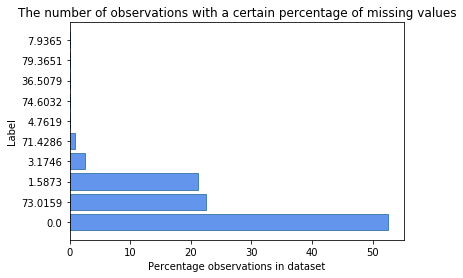

---------------------------------------------------------------------------------------------------- 
Broader exploration of the data
 ----------------------------------------------------------------------------------------------------
Total number of observations: 15514 

Total number of observations with no missing values: 8162 ( 52.6105 %)

The number of observations for which more than half of the information is missing: 3654 ( 23.5529 %)


   Jungle 
---------------------------------------------------------------------------------------------------- 
Overview of variable:  The number of observations with a certain percentage of missing values 
 ----------------------------------------------------------------------------------------------------
Total categories: 10 



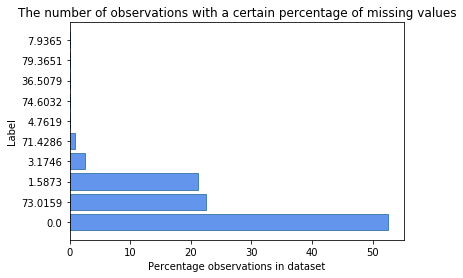

---------------------------------------------------------------------------------------------------- 
Broader exploration of the data
 ----------------------------------------------------------------------------------------------------
Total number of observations: 15514 

Total number of observations with no missing values: 8162 ( 52.6105 %)

The number of observations for which more than half of the information is missing: 3654 ( 23.5529 %)


   ADC 
---------------------------------------------------------------------------------------------------- 
Overview of variable:  The number of observations with a certain percentage of missing values 
 ----------------------------------------------------------------------------------------------------
Total categories: 10 



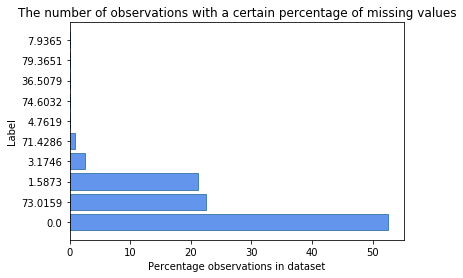

---------------------------------------------------------------------------------------------------- 
Broader exploration of the data
 ----------------------------------------------------------------------------------------------------
Total number of observations: 15514 

Total number of observations with no missing values: 8162 ( 52.6105 %)

The number of observations for which more than half of the information is missing: 3654 ( 23.5529 %)


   Support 
---------------------------------------------------------------------------------------------------- 
Overview of variable:  The number of observations with a certain percentage of missing values 
 ----------------------------------------------------------------------------------------------------
Total categories: 12 



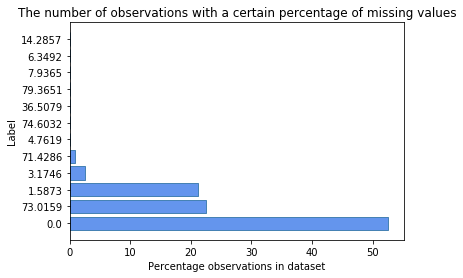

---------------------------------------------------------------------------------------------------- 
Broader exploration of the data
 ----------------------------------------------------------------------------------------------------
Total number of observations: 15514 

Total number of observations with no missing values: 8160 ( 52.5977 %)

The number of observations for which more than half of the information is missing: 3654 ( 23.5529 %)


In [30]:
# Loop through the different dataframes
for pos, df in data_dict.items():
    # Print represented position for visualization purposes
    print("\n\n","="*10, "\n  ", pos, "\n", "="*10)
    
    # Count of rows with a certain number of missing values
    percentage_missing_perobs = [round(x/len(df.columns)*100, 4) for x in list(df.isna().sum(axis=1))]
    SummaryCategoricalVar(percentage_missing_perobs,
                          'The number of observations with a certain percentage of missing values')

    # Print intermediate summary
    print("-"*100, "\nBroader exploration of the data\n", "-"*100)
    print("Total number of observations:", len(percentage_missing_perobs), "\n")
    print("Total number of observations with no missing values:", 
          len([x for x in percentage_missing_perobs if x == 0]),
         "(", round(len([x for x in percentage_missing_perobs if x == 0])/len(percentage_missing_perobs)*100, 4), "%)\n")
    print("The number of observations for which more than half of the information is missing:", 
          len([x for x in percentage_missing_perobs if x > 50]),
         "(", round(len([x for x in percentage_missing_perobs if x > 50])/len(percentage_missing_perobs)*100, 4), "%)")

##### Detailed investigation 'observations with many missing values'
Hence the data distributions presented here correspond to the subset of the observations for which more than half the column information is missing.

In [31]:
# Extract subdataset to get detailed insight into the observations with many missing values
obs_missing_info = [teller for teller, x in enumerate(percentage_missing_perobs) if x > 50]
obs_missing_info_df = data_preparation.iloc[obs_missing_info,:]

---------------------------------------------------------------------------------------------------- 
Overview of variable:  The number of observations with a certain percentage of missing values 
 ----------------------------------------------------------------------------------------------------
Total categories: 6 



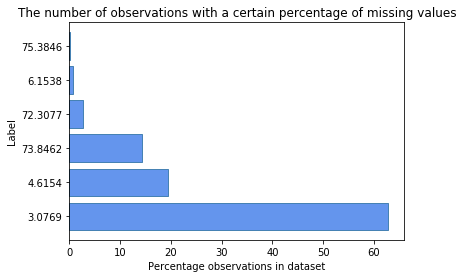

In [32]:
# Distribution of percentage missing values
SummaryCategoricalVar([round(x/len(obs_missing_info_df.columns)*100, 4) for x in list(obs_missing_info_df.isna().sum(axis=1))], 
                      'The number of observations with a certain percentage of missing values')

Next, it will be explored whether some column categories are represented more by the observations with a lot of missing data. Latter results need to be compared with the representations of the categorical covariates in the whole dataset (as considered below).

---------------------------------------------------------------------------------------------------- 
Overview of variable:  gameid 
 ----------------------------------------------------------------------------------------------------
Total categories: 424 

The 10 with the highest percentage data available:

1001910133 : 0.2737 %
1001910125 : 0.2737 %
1001910119 : 0.2737 %
1001910097 : 0.2737 %
1001900079 : 0.2737 %
30435 : 0.2737 %
30432 : 0.2737 %
30380 : 0.2737 %
20394 : 0.2737 %
30358 : 0.2737 %

The 10 with the lowest percentage data available:

240118 : 0.0547 %
1170656 : 0.0547 %
1160463 : 0.0547 %
1002240116 : 0.0547 %
1160150 : 0.0547 %
210197 : 0.0547 %
2017-213OMGJD Gaming : 0.0547 %
1002110106 : 0.0547 %
210324 : 0.0547 %
1002100125 : 0.0547 %
---------------------------------------------------------------------------------------------------- 
Overview of variable:  league 
 ---------------------------------------------------------------------------------------------------

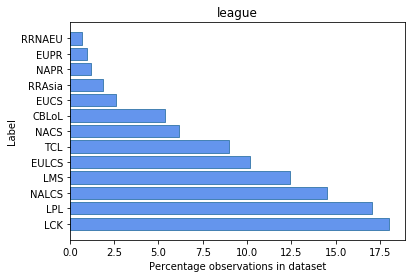

---------------------------------------------------------------------------------------------------- 
Overview of variable:  game 
 ----------------------------------------------------------------------------------------------------
Total categories: 8 



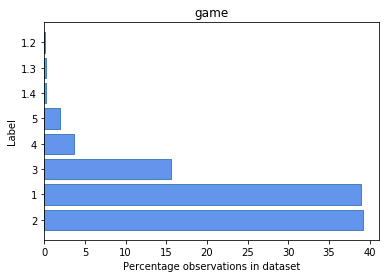

---------------------------------------------------------------------------------------------------- 
Overview of variable:  side 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



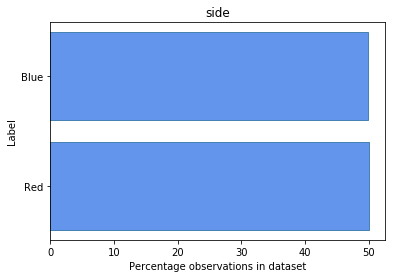

---------------------------------------------------------------------------------------------------- 
Overview of variable:  position 
 ----------------------------------------------------------------------------------------------------
Total categories: 5 



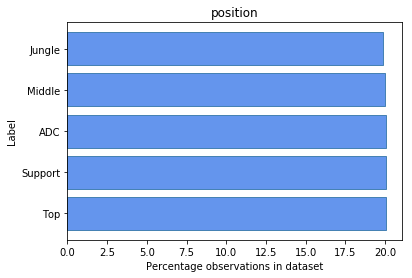

---------------------------------------------------------------------------------------------------- 
Overview of variable:  champion 
 ----------------------------------------------------------------------------------------------------
Total categories: 104 

The 10 with the highest percentage data available:

Gragas : 4.8166 %
Jarvan IV : 4.4335 %
Thresh : 3.8314 %
Braum : 3.2567 %
Tristana : 3.1746 %
Orianna : 3.0925 %
Kalista : 2.8736 %
Varus : 2.8462 %
Corki : 2.8188 %
Galio : 2.5999 %

The 10 with the lowest percentage data available:

Singed : 0.0274 %
Nami : 0.0274 %
Fizz : 0.0274 %
Evelynn : 0.0274 %
Quinn : 0.0274 %
Veigar : 0.0274 %
Akali : 0.0274 %
Nocturne : 0.0274 %
Yasuo : 0.0274 %
Riven : 0.0274 %
---------------------------------------------------------------------------------------------------- 
Overview of variable:  Year 
 ----------------------------------------------------------------------------------------------------
Total categories: 1 



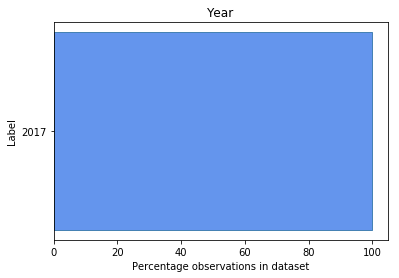

---------------------------------------------------------------------------------------------------- 
Overview of variable:  player 
 ----------------------------------------------------------------------------------------------------
Total categories: 509 

The 10 with the highest percentage data available:

xiyang : 0.5747 %
five : 0.5747 %
icon : 0.5747 %
smlz : 0.52 %
breeze : 0.4926 %
wako : 0.4926 %
epic : 0.4926 %
holyphoenix : 0.4652 %
marin : 0.4652 %
max : 0.4652 %

The 10 with the lowest percentage data available:

juzinho : 0.0274 %
kuku : 0.0274 %
shady : 0.0274 %
amades : 0.0274 %
shoshin : 0.0274 %
clid : 0.0274 %
barrett : 0.0274 %
lbb : 0.0274 %
comeback : 0.0274 %
rascal : 0.0274 %
---------------------------------------------------------------------------------------------------- 
Overview of variable:  culture 
 ----------------------------------------------------------------------------------------------------
Total categories: 8 



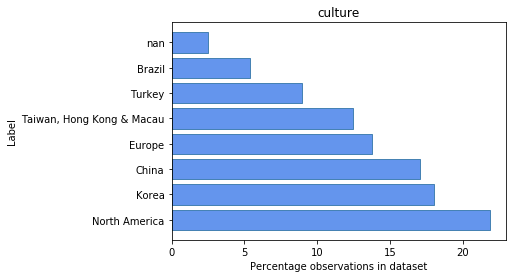

---------------------------------------------------------------------------------------------------- 
Overview of variable:  team 
 ----------------------------------------------------------------------------------------------------
Total categories: 80 

The 10 with the highest percentage data available:

omg : 2.8736 %
counter logic gaming : 2.5452 %
wayi spider : 2.4904 %
dark passage : 2.2715 %
dignitas : 2.2715 %
mvp : 2.2441 %
team liquid : 2.1346 %
cloud9 : 2.1073 %
afreeca freecs : 2.1073 %
suning : 1.9978 %

The 10 with the lowest percentage data available:

fire ball : 0.4105 %
delta fox : 0.4105 %
keyd stars : 0.3558 %
kongdoo monster : 0.2737 %
17 academy : 0.2737 %
origen : 0.2737 %
paris saint-germain : 0.2737 %
wind and rain : 0.2737 %
hong kong esports : 0.1368 %
roccat : 0.1368 %


In [33]:
# Loop through all categorical variables and visualize data
for cat_variable in categorical_variables:
    SummaryCategoricalVar(obs_missing_info_df[cat_variable], cat_variable)

### 6.3 Missing value imputation
To impute missing values the following techniques are applied:
* Categorical covariates: random sampling from the discrete distribution representing the probabilities of a value being from a certain category for that covariate. Because of the large amount of data available, it might be interesting to do imputation by sampling randomly from the distribution of available values for a specific covariate, to obtain the least biased estimation of the missing value. It is nevertheless important to get a clear insight into the data with a lot of missing data as well, because these could be biased towards certain column values and hence should be treated with care.
* Numerical covariates: Median imputation.

In [34]:
# Loop through the different dataframes
for pos, df in data_dict.items():    
    # Probability based missing value imptation (categorical covariates) and median imputation (numerical covariates)
    for col in df.columns.values:
        if df[col].isna().sum() > 0:
            if col in categorical_variables:
                df[col] = df[col].fillna(RandomSampleProbDist(df[col]))
            elif col in numerical_variables:
                df[col] = df[col].fillna(np.median(df[col].dropna()))
                
    # Assign imputed df to dataframe dictionary
    data_dict[pos] = df

In [35]:
# Loop through the different dataframes
print("Detection of non-imputed missing values in the data:")
for pos, df in data_dict.items():   
    # Check whether there are still non-imputed missing values in the data
    print(pos, ":", np.any(df.isnull()))

Detection of non-imputed missing values in the data:
Top : False
Middle : False
Jungle : False
ADC : False
Support : False


In [36]:
# Write data away in pickle
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + filename + '_top.pickle', 'wb') as f:
    pickle.dump(data_dict['Top'], f)
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + filename + '_mid.pickle', 'wb') as f:
    pickle.dump(data_dict['Middle'], f)
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + filename + '_jun.pickle', 'wb') as f:
    pickle.dump(data_dict['Jungle'], f)
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + filename + '_adc.pickle', 'wb') as f:
    pickle.dump(data_dict['ADC'], f)
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + filename + '_sup.pickle', 'wb') as f:
    pickle.dump(data_dict['Support'], f)